# Trend Assessment of Satellite-Derived Surface Albedo for Studying the Caspian Sea Retreat: A Climate Monitoring and Scientific Study

## 🌍 Use case: Estimation of Caspian sea retreat using surface albedo

## ❓ Quality assessment question
**Can the satellite albedo datasets be used for studying the retreat of the Caspian Sea Basin?**

The Caspian Sea is the world's largest inland water body [1]. However, the body of water has been found to be shrinking over the past many years. It is being warned that the Caspian Sea could decline by 9–18 meters by the end of the century [2]. The shrinking size of the sea would adversely affect the ecosystem, food security, and livelihoods of many people, with various socio-economic consequences and local and regional conflicts [3]. In this application, we will use the surface albedo from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) to assess the driest regions of Caspian Sea. The lakewater levels from 2006 to 2020, derived from satellite observations, shall also be collected for the same time period. The application also shows the consistency between two CDS datasets.
 This notebook assesses the capability of the albedo dataset in capturing the retreat of the Caspian Sea. It was concluded that the CDS surface albedo 10-daily gridded dataset is capable of capturing the retreat of the Caspian Sea, consistently with the satellite retrieval of the lake water level.

## 📢 Quality assessment statement

* The CDS surface albedo 10-daily gridded dataset is capable of capturing the retreat of the Caspian Sea.
* In the selected area of the northern Caspian Sea, the trend of surface albedo exhibits a stable seasonal behavior with a decrease in maximum values recorded due to the reduced snowfalls. The surface albedo has increased since 2016 in agreement with the lowering of lake water depth at a level enabling the satellite measurements to be sensitive to the lake floor and to the underwater vegetation.
* The obtained albedo trend aligns with other studies (Akbari et al., 2022; Lahijani et. al., 2023), which indicate minor changes in Caspian water level with an overall falling trend.
* Previous studies (Chen et al., 2017; Samant and Prange, 2023) reveal a Caspian Sea level decline of ~1.5 m in 26 years (i.e., 7 cm/year) during the time period 1996–2021, and the decline has intensified (i.e., 10 cm/year) in recent years during 2006–2021.
* This study shows that CDS surface albedo can be used to capture the retreat of the Caspian Sea, when lakewater depth becomes small due to seasonal changes in the hydrological cycle.

## 📋 Methodology
1. Geographic data representation.
2. Download surface albedo data SPOT VGT v2 (time period 2006–2014)
(horizontal_resolution: ~ 1 km) and PROBA VGT v2 (time period 2014–2021)
(horizontal_resolution: ~ 1 km). And download satellite lake water level data version 4.0 for the Caspian Sea (southwestern Asia).
3. Create a time series of albedo and lake water level over the selected area of the northern Caspian Sea.

## 📈 Analysis and results

(section-1)=
### 1. Geographic data representation.

The selected area near the northern Caspian Sea encompasses both land and sea regions. This visualization is important for interpreting the results because albedo in land areas can differ significantly from that of water bodies. Snow-covered land typically exhibits a much higher albedo compared to open water, reflecting more solar radiation and thus influencing local temperature and climate patterns.

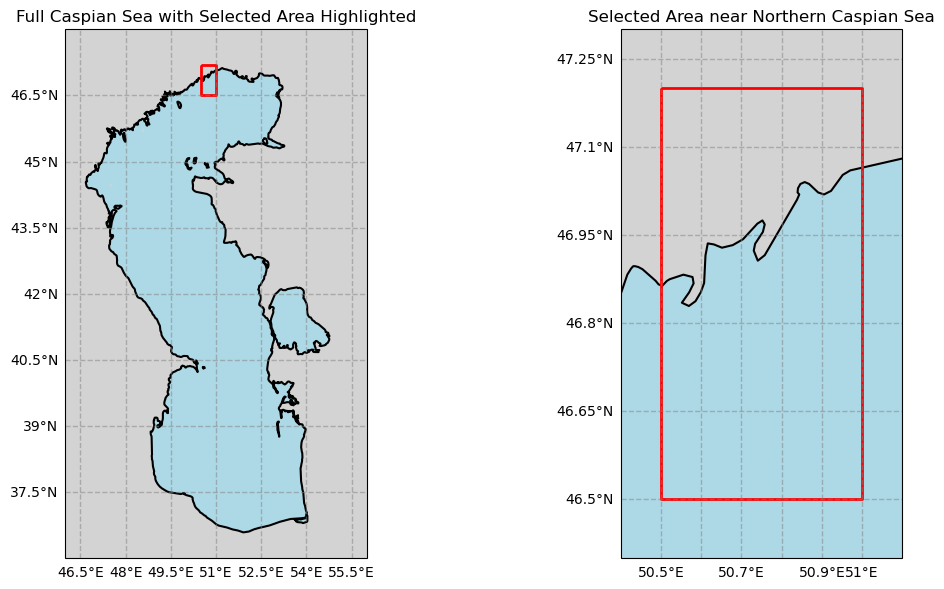

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import geopandas as gpd

coordinates = [(50.5, 47.2), (51.0, 47.2), (51.0, 46.5), (50.5, 46.5), (50.5, 47.2)]
polygon = Polygon(coordinates)
gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs="EPSG:4326")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: Full Caspian Sea with indication of selected area
ax1.add_feature(cfeature.LAND, color='lightgray')           
ax1.add_feature(cfeature.OCEAN, color='lightblue')          
ax1.add_feature(cfeature.COASTLINE, linewidth=1.5)          
ax1.set_extent([46, 56, 36, 48], crs=ccrs.PlateCarree())   


gdf.boundary.plot(ax=ax1, color='red', linewidth=2, transform=ccrs.PlateCarree())
gl1 = ax1.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl1.top_labels = False
gl1.right_labels = False
ax1.set_title('Full Caspian Sea with Selected Area Highlighted', fontsize=12)

# Plot 2: Zoomed-in region near Northern Caspian Sea 
ax2.add_feature(cfeature.LAND, color='lightgray')          
ax2.add_feature(cfeature.OCEAN, color='lightblue')          
ax2.add_feature(cfeature.COASTLINE, linewidth=1.5)         
# Plot the selected region
gdf.boundary.plot(ax=ax2, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax2.set_xlim(50.4, 51.1)
ax2.set_ylim(46.4, 47.3)
gl2 = ax2.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl2.top_labels = False
gl2.right_labels = False
ax2.set_title('Selected Area near Northern Caspian Sea', fontsize=12)

plt.tight_layout()
plt.show()


(section-2)=
### 2. Download surface albedo and lake water level data
We used standard libraries (numpy, pandas, xarray, cartopy, matplotlib.colors, matplotlib.pyplot) for this notebook. First, we defined the parameters and transformed the data and finally the data was downloaded for both albedo and lake water level.

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from c3s_eqc_automatic_quality_control import diagnostics, download
import numpy as np
plt.style.use("seaborn-v0_8-notebook")



collection_id = "satellite-albedo"
chunks = {"year": 1}

common_request = {"format": "zip",
    "variable": "albb_bh",
    "product_version": "v2",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "nominal_day": "10",
    "area": [46.91, 50.75, 46.81, 50.85],
    
}
requests = {
    "spot": {
       "year": [str(year) for year in range(2006, 2014)],
        "horizontal_resolution": "1km",
        "sensor": "vgt",
    },
    "proba": {
        "year": [str(year) for year in range(2014, 2021)],
        "horizontal_resolution": "1km",
        "sensor": "vgt",
    },
}


collection_id_lake = "satellite-lake-water-level"
request_lake = {
    "variable": "water_surface_height_above_reference_datum",
   "version": "version_4_0",
    "format": "zip",
    "lake": "caspian",
    "region": "southwestern_asia",
}


maps = {}
timeseries = []
for satellite, request in requests.items():
    print(f"{satellite=}")

    maps[satellite] = download.download_and_transform(
        collection_id,
        common_request | request | {"satellite": satellite},
        chunks=chunks,
        transform_chunks=False,
        transform_func=diagnostics.time_weighted_mean,
        drop_variables=["crs"],
    )

    ds = download.download_and_transform(
        collection_id,
        common_request | request | {"satellite": satellite},
        chunks=chunks,
        transform_func=diagnostics.spatial_weighted_mean,
        drop_variables=["crs"],
    )
    timeseries.append(ds)

ds_timeseries = xr.concat(timeseries, "time")
ds_lake = download.download_and_transform(collection_id_lake, request_lake)
ds_lake_subset = ds_lake.sel(time=slice("2006-01-01", "2020-06-30"))


satellite='spot'


100%|██████████| 8/8 [00:00<00:00, 31.55it/s]


satellite='proba'


100%|██████████| 1/1 [00:00<00:00, 22.26it/s]


(section-3)=
### 3. Plot timeseries
we plotted the time series of albedo and water surface height data.

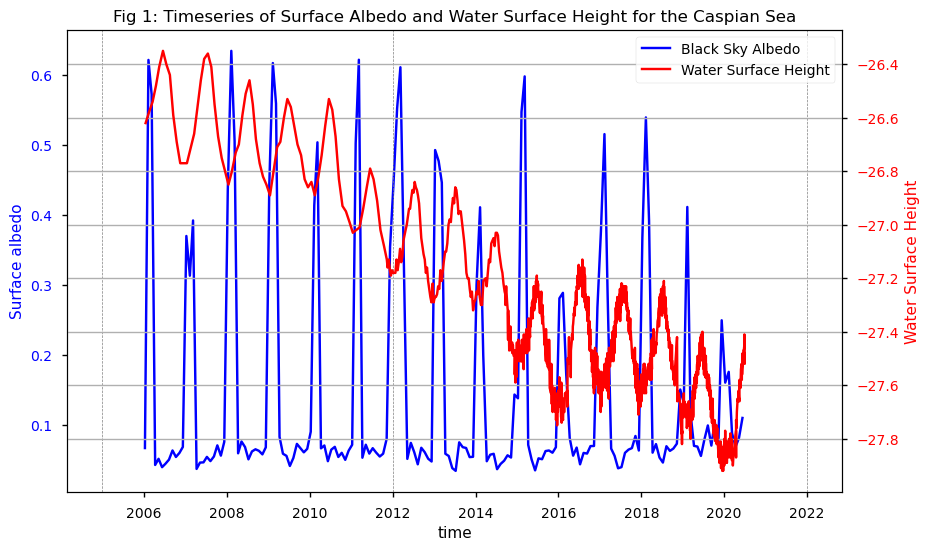

In [4]:
# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first variable from ds_timeseries
ds_timeseries["AL_BH_BB"].plot(ax=ax1, color='blue', label='Black Sky Albedo')
ax1.set_ylabel('Surface albedo', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Check if the variable exists in ds and plot it
if "water_surface_height_above_reference_datum" in ds_lake_subset:
    # Create a twin axis sharing the x-axis
    ax2 = ax1.twinx() # Plot the variable from ds if it exists
    ds_lake_subset["water_surface_height_above_reference_datum"].plot(ax=ax2, color='red', label='Water Surface Height')
    ax2.set_ylabel('Water Surface Height', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Add vertical lines
vertical_lines = ['2005-01-01', '2012-01-01', '2021-12-31']
for line in vertical_lines:
    ax1.axvline(x=datetime.strptime(line, '%Y-%m-%d'), color='gray', linestyle='--', linewidth=0.5)
    if "water_surface_height_above_reference_datum" in ds:
        ax2.axvline(x=datetime.strptime(line, '%Y-%m-%d'), color='gray', linestyle='--', linewidth=0.5)

# Set title
plt.title("Fig 1: Timeseries of Surface Albedo and Water Surface Height for the Caspian Sea")

# Show grid
plt.grid()
plt.show()

### Results

1. The albedo plot shows significant snowfall in the selected region near the northern Caspian Sea during winter months, with a mean albedo of about 0.6. This value indicates that the area includes both land and water surfaces, as a range of 0.5 to 0.6 is typical for snow-covered ground. However, albedo has not reached 0.6 since 2012, suggesting reduced snowfall. This happens as the water's surface height begins to decline.
2. Since 2016, the minimum albedo has increased, indicating that the selected area has retreated and become less submerged. As land becomes more exposed, it can accumulate snow, further affecting albedo. The map of the selected area clarifies these observations.
3. The monthly data clearly exhibits oscillatory behavior in both surface albedo and water surface height, which likely reflects seasonal cycles.
4. There appears to be a lagged relationship between albedo peaks and subsequent increases in water surface height, which might be explained by the delayed impact of snowmelt on water levels [5].
   

## ℹ️ If you want to know more

### References

1. Akbari, E., Hamzeh, S., Kakroodi, A. A., & Maanan, M. (2022). Time series analysis of the    Caspian Sea shoreline in response to sea level fluctuation using remotely sensed data.       Regional Studies in Marine Science, 56, 102672.
2. Lahijani, H., Leroy, S. A. G., Arpe, K., & Cretaux, J. F. (2023). Caspian Sea level          changes during instrumental period, its impact and forecast: A review. Earth-Science         Reviews, 241, 104428.
3. Samant, R., & Prange, M. (2023). Climate-driven 21st century Caspian Sea level decline       estimated from CMIP6 projections. Communications Earth & Environment, 4(1), 357.
4. Chen, J. L., Pekker, T., Wilson, C. R., Tapley, B. D., Kostianoy, A. G., Cretaux, J. F.,     & Safarov, E. S. (2017). Long‐term Caspian Sea level change. Geophysical Research            Letters, 44(13), 6993-7001.
5. Argaman, E., Keesstra, S. D., & Zeiliguer, A. (2012). Monitoring the impact of surface albedo on a saline lake in SW Russia. Land Degradation & Development, 23(4), 398-408.